## <font color=#6B49F5> A Simple Implementation of FedAvg with PyTorch on IID Data </font> 
Please see https://towardsdatascience.com/federated-learning-a-simple-implementation-of-fedavg-federated-averaging-with-pytorch-90187c9c9577 for more details.

In [2]:

!pip install torch

In [1]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import random
import math
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot


from pathlib import Path
import requests
import pickle
import gzip

import torch
import math
import torch.nn.functional as F
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

pd.options.display.float_format = "{:,.4f}".format

In [2]:
from keras.datasets import mnist,cifar10
(train_X, train_y), (test_X, test_y) = cifar10.load_data()



In [64]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

In [65]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))


X_train: (50000, 32, 32, 3)
Y_train: (50000, 1)
X_test:  (10000, 32, 32, 3)
Y_test:  (10000, 1)


In [75]:
X_train = train_X.reshape(50000, 32*32*3)

In [7]:

X_test  = test_X.reshape(10000, 784)

In [8]:
X_train.shape

(60000, 784)

In [4]:
X_train = train_X.astype('float32') 
X_test  = test_X.astype('float32')
X_train /= 255 # Original data is uint8 (0-255). Scale it to range [0,1].
X_test  /= 255
print("Training X matrix shape", X_train.shape)
print("Testing X matrix shape", X_test.shape)

Training X matrix shape (50000, 32, 32, 3)
Testing X matrix shape (10000, 32, 32, 3)


In [10]:
train_y.shape

(60000,)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, train_y, test_size=10000, random_state=1) # 0.25 x 0.8 = 0.2

In [6]:
y_test = test_y

In [7]:
print("Training X matrix shape", X_train.shape)
print("Testing X matrix shape", X_test.shape)
print("Val X matrix shape", X_val.shape)
print("Training y matrix shape", y_train.shape)
print("Testing y matrix shape", y_test.shape)
print("Val y matrix shape", y_val.shape)

Training X matrix shape (40000, 32, 32, 3)
Testing X matrix shape (10000, 32, 32, 3)
Val X matrix shape (10000, 32, 32, 3)
Training y matrix shape (40000, 1)
Testing y matrix shape (10000, 1)
Val y matrix shape (10000, 1)


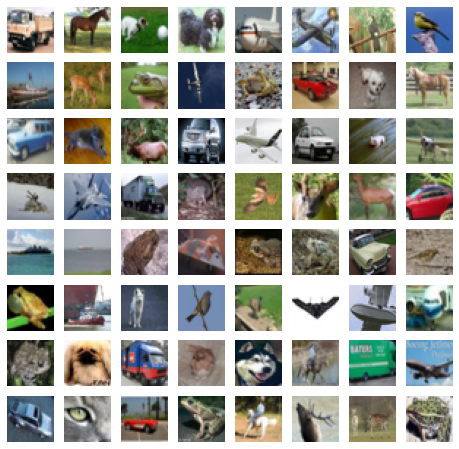

In [81]:
fig, axes = pyplot.subplots(8,8,figsize=(8,8))
for i in range(8):
    for j in range(8):
        num_index = np.random.randint(len(X_train))
        axes[i,j].imshow(X_train[num_index], cmap="gray")
        axes[i,j].axis("off")
pyplot.show() 

**Let's check how many of each tag are**

In [82]:
# Let's check how many of each tag are.
y_train_total=0
y_valid_total=0
y_test_total=0
total=0
for i in range(10):
    print(i,">> train:", sum(y_train==i), ", valid:", sum(y_val==i), 
          ", test:", sum(y_test==i), ", total:", sum(y_train==i)+sum(y_val==i)+sum(y_test==i) )
    y_train_total=y_train_total + sum(y_train==i)
    y_valid_total=y_valid_total + sum(y_val==i)
    y_test_total=y_test_total + sum(y_test==i)
    total=total+sum(y_train==i)+sum(y_val==i)+sum(y_test==i)
    
print("y_train_total=", y_train_total) 
print("y_valid_total=", y_valid_total) 
print("y_test_total=", y_test_total)
print("total=", total)

TypeError: unsupported operand type(s) for +: 'numpy.ndarray' and 'Tensor'

In [8]:
def split_and_shuffle_labels(y_data, seed, amount):
    y_data=pd.DataFrame(y_data,columns=["labels"])
    y_data["i"]=np.arange(len(y_data))
    label_dict = dict()
    for i in range(10):
        var_name="label" + str(i)
        label_info=y_data[y_data["labels"]==i]
        np.random.seed(seed)
        label_info=np.random.permutation(label_info)
        label_info=label_info[0:amount]
        label_info=pd.DataFrame(label_info, columns=["labels","i"])
        label_dict.update({var_name: label_info })
    return label_dict

In [9]:
def get_iid_subsamples_indices(label_dict, number_of_samples, amount):
    sample_dict= dict()
    batch_size=int(math.floor(amount/number_of_samples))
    for i in range(number_of_samples):
        sample_name="sample"+str(i)
        dumb=pd.DataFrame()
        for j in range(10):
            label_name=str("label")+str(j)
            a=label_dict[label_name][i*batch_size:(i+1)*batch_size]
            dumb=pd.concat([dumb,a], axis=0)
        dumb.reset_index(drop=True, inplace=True)    
        sample_dict.update({sample_name: dumb}) 
    return sample_dict

In [10]:
def create_iid_subsamples(sample_dict, x_data, y_data, x_name, y_name):
    x_data_dict= dict()
    y_data_dict= dict()
    
    for i in range(len(sample_dict)):  ### len(sample_dict)= number of samples
        xname= x_name+str(i)
        yname= y_name+str(i)
        sample_name="sample"+str(i)
        
        indices=np.sort(np.array(sample_dict[sample_name]["i"]))
        
        x_info= x_data[indices,:]
        x_data_dict.update({xname : x_info})
        
        y_info= y_data[indices]
        y_data_dict.update({yname : y_info})
        
    return x_data_dict, y_data_dict

--------------------------
### <span style="background-color:#F087F9"> Classification Model </span> 

In [37]:

import torch.nn as nn
class Net2nn(nn.Module):   
    def __init__(self):
        
        super(Net2nn, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(8192, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
#         print(x.shape)
        # fc layer
        x = self.fc_layer(x)

        return x
    # class Net2nn(nn.Module):
#     def __init__(self):
#         super(Net2nn, self).__init__()
#         self.fc1=nn.Linear(784,200)
#         self.fc2=nn.Linear(200,200)
#         self.fc3=nn.Linear(200,10)
        
#     def forward(self,x):
#         x=F.relu(self.fc1(x))
#         x=F.relu(self.fc2(x))
#         x=self.fc3(x)
#         return x

In [12]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [13]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    correct = 0

    for data, target in train_loader:
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        prediction = output.argmax(dim=1, keepdim=True)
        correct += prediction.eq(target.view_as(prediction)).sum().item()
        

    return train_loss / len(train_loader), correct/len(train_loader.dataset)

In [16]:
# centralized_model.eval()
# correct = 0.0
# total_correct = 0.0
# with torch.no_grad():
#     for data, target in test_dl:
#         output = centralized_model(data)
#         prediction = output.argmax(dim=1, keepdim=True)
#         print(prediction,target.reshape(-1,1))
#         target = target.reshape(-1,1)
#         correct = prediction.eq(target.view_as(prediction)).sum().item()
# #         print(correct/len(data))
#         total_correct += correct
        


In [14]:
def validation(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            
            test_loss += criterion(output, target).item()
            prediction = output.argmax(dim=1, keepdim=True)
            target = target.reshape(-1,1)
            correct += prediction.eq(target.view_as(prediction)).sum().item()
    print(correct)
    test_loss /= len(test_loader)
    correct /= len(test_loader.dataset)

    return (test_loss, correct)

---------------------------------
### <span style="background-color:#F087F9"> Functions for Federated Averaging </span> 

In [15]:
def create_model_optimizer_criterion_dict(number_of_samples,learning_rate,momentum):
    model_dict = dict()
    optimizer_dict= dict()
    criterion_dict = dict()
    
    for i in range(number_of_samples):
        model_name="model"+str(i)
        model_info=Net2nn()
        model_dict.update({model_name : model_info })
        
        optimizer_name="optimizer"+str(i)
        optimizer_info = torch.optim.SGD(model_info.parameters(), lr=learning_rate, momentum=momentum)
        optimizer_dict.update({optimizer_name : optimizer_info })
        
        criterion_name = "criterion"+str(i)
        criterion_info = nn.CrossEntropyLoss()
        criterion_dict.update({criterion_name : criterion_info})
        
    return model_dict, optimizer_dict, criterion_dict 

In [16]:
# with torch.no_grad():
#     model_4.conv_layer[0].weight.data = (model_3.conv_layer[0].weight.data.clone() + model_1.conv_layer[0].weight.data.clone() + model_2.conv_layer[0].weight.data.clone())/3
#     model_4.conv_layer[0].bias.data = (model_3.conv_layer[0].bias.data.clone() + model_2.conv_layer[0].bias.data.clone() + model_1.conv_layer[0].bias.data.clone()) / len(models) 
#     model_4.conv_layer[1].weight.data = (model_3.conv_layer[1].weight.data.clone() + model_2.conv_layer[1].weight.data.clone() + model_1.conv_layer[1].weight.data.clone()) / len(models)
#     model_4.conv_layer[1].bias.data = (model_3.conv_layer[1].bias.data.clone() + model_2.conv_layer[1].bias.data.clone() + model_1.conv_layer[1].bias.data.clone()) / len(models)
#     model_4.conv_layer[3].weight.data = (model_3.conv_layer[3].weight.data.clone() + model_2.conv_layer[3].weight.data.clone() + model_1.conv_layer[3].weight.data.clone()) / len(models) 
#     model_4.conv_layer[3].bias.data = (model_3.conv_layer[3].bias.data.clone() + model_2.conv_layer[3].bias.data.clone() + model_1.conv_layer[3].bias.data.clone()) / len(models) 
#     model_4.conv_layer[6].weight.data = (model_3.conv_layer[6].weight.data.clone() + model_2.conv_layer[6].weight.data.clone() + model_1.conv_layer[6].weight.data.clone() ) / len(models)
#     model_4.conv_layer[6].bias.data = (model_3.conv_layer[6].bias.data.clone() + model_2.conv_layer[6].bias.data.clone() + model_1.conv_layer[6].bias.data.clone() ) / len(models)
#     model_4.conv_layer[7].weight.data = (model_3.conv_layer[7].weight.data.clone() + model_1.conv_layer[7].weight.data.clone() + model_1.conv_layer[7].weight.data.clone() ) / len(models)
#     model_4.conv_layer[7].bias.data = (model_3.conv_layer[7].bias.data.clone() + model_2.conv_layer[7].bias.data.clone() + model_1.conv_layer[7].bias.data.clone() ) / len(models)
#     model_4.conv_layer[9].weight.data = (model_3.conv_layer[9].weight.data.clone() + model_2.conv_layer[9].weight.data.clone() + model_1.conv_layer[9].weight.data.clone() ) / len(models)
#     model_4.conv_layer[9].bias.data = (model_3.conv_layer[9].bias.data.clone() + model_2.conv_layer[9].bias.data.clone() + model_1.conv_layer[9].bias.data.clone() ) / len(models)
#     model_4.fc_layer[1].weight.data = (model_3.fc_layer[1].weight.data.clone() + model_2.fc_layer[1].weight.data.clone() + model_1.fc_layer[1].weight.data.clone() ) / len(models)
#     model_4.fc_layer[1].bias.data = (model_3.fc_layer[1].bias.data.clone() + model_2.fc_layer[1].bias.data.clone() + model_1.fc_layer[1].bias.data.clone() ) / len(models)
#     model_4.fc_layer[4].weight.data = (model_3.fc_layer[4].weight.data.clone() + model_2.fc_layer[4].weight.data.clone() + model_1.fc_layer[4].weight.data.clone() ) / len(models)
#     model_4.fc_layer[4].bias.data = (model_3.fc_layer[4].bias.data.clone() + model_2.fc_layer[4].bias.data.clone() + model_1.fc_layer[4].bias.data.clone() ) / len(models)

In [116]:
centralized_model = Net2nn()

In [117]:
for p in centralized_model.state_dict().keys():
    print(p)

conv_layer.0.weight
conv_layer.0.bias
conv_layer.1.weight
conv_layer.1.bias
conv_layer.1.running_mean
conv_layer.1.running_var
conv_layer.1.num_batches_tracked
conv_layer.3.weight
conv_layer.3.bias
conv_layer.6.weight
conv_layer.6.bias
conv_layer.7.weight
conv_layer.7.bias
conv_layer.7.running_mean
conv_layer.7.running_var
conv_layer.7.num_batches_tracked
conv_layer.9.weight
conv_layer.9.bias
fc_layer.1.weight
fc_layer.1.bias
fc_layer.3.weight
fc_layer.3.bias
fc_layer.6.weight
fc_layer.6.bias


In [17]:
def get_averaged_weights(model_dict, number_of_samples):
    status_dict = {}
    with torch.no_grad():
        for name in model_dict[name_of_models[0]].state_dict().keys():
            print(name)
            data = torch.zeros(
                    size=model_dict[name_of_models[0]].state_dict()[name].shape)
            for i in range(number_of_samples):
                m = model_dict[name_of_models[i]] 
                data += m.state_dict()[name].data.clone()
            data = data / number_of_samples
            status_dict[name] = data
    return status_dict

In [18]:
def set_averaged_weights_as_main_model_weights_and_update_main_model(main_model,model_dict, number_of_samples):
    status_dict = get_averaged_weights(model_dict, number_of_samples=number_of_samples)
    with torch.no_grad():
        main_model.load_state_dict(status_dict)
    return main_model

In [120]:
def get_averaged_weights(model_dict, number_of_samples):
    conv_layer_0_weight = torch.zeros(
        size=model_dict[name_of_models[0]].conv_layer[0].weight.shape)
    conv_layer_0_bias = torch.zeros(
        size=model_dict[name_of_models[0]].conv_layer[0].bias.shape)
    conv_layer_1_weight =torch.zeros(
        size=model_dict[name_of_models[0]].conv_layer[1].weight.shape)
    conv_layer_1_bias = torch.zeros(
        size=model_dict[name_of_models[0]].conv_layer[1].bias.shape)
    
    conv_layer_1_running_mean = torch.zeros(
        size=model_dict[name_of_models[0]].conv_layer[1].running_mean.shape)
    conv_layer_1_running_var = torch.zeros(
        size=model_dict[name_of_models[0]].conv_layer[1].running_var.shape)
    conv_layer_1_num_batches_tracked = torch.zeros(
        size=model_dict[name_of_models[0]].conv_layer[1].num_batches_tracked.shape)

    conv_layer_3_weight = torch.zeros(
        size=model_dict[name_of_models[0]].conv_layer[3].weight.shape)
    conv_layer_3_bias = torch.zeros(
        size=model_dict[name_of_models[0]].conv_layer[3].bias.shape)
    conv_layer_6_weight =torch.zeros(
        size=model_dict[name_of_models[0]].conv_layer[6].weight.shape)
    conv_layer_6_bias = torch.zeros(
        size=model_dict[name_of_models[0]].conv_layer[6].bias.shape)
    conv_layer_7_weight =torch.zeros(
        size=model_dict[name_of_models[0]].conv_layer[7].weight.shape)
    conv_layer_7_bias = torch.zeros(
        size=model_dict[name_of_models[0]].conv_layer[7].bias.shape)
    conv_layer_7_running_mean = torch.zeros(
        size=model_dict[name_of_models[0]].conv_layer[7].running_mean.shape)
    conv_layer_7_running_var = torch.zeros(
        size=model_dict[name_of_models[0]].conv_layer[7].running_var.shape)
    conv_layer_7_num_batches_tracked = torch.zeros(
        size=model_dict[name_of_models[0]].conv_layer[7].num_batches_tracked.shape)
    conv_layer_9_weight =torch.zeros(
        size=model_dict[name_of_models[0]].conv_layer[9].weight.shape)
    conv_layer_9_bias = torch.zeros(
        size=model_dict[name_of_models[0]].conv_layer[9].bias.shape)
    fc_layer_1_weight = torch.zeros(
        size=model_dict[name_of_models[0]].fc_layer[1].weight.shape)
    fc_layer_1_bias = torch.zeros(
        size=model_dict[name_of_models[0]].fc_layer[1].bias.shape)
    fc_layer_3_weight = torch.zeros(
        size=model_dict[name_of_models[0]].fc_layer[3].weight.shape)
    fc_layer_3_bias = torch.zeros(
        size=model_dict[name_of_models[0]].fc_layer[3].bias.shape)
    fc_layer_6_weight = torch.zeros(
        size=model_dict[name_of_models[0]].fc_layer[6].weight.shape)
    fc_layer_6_bias = torch.zeros(
        size=model_dict[name_of_models[0]].fc_layer[6].bias.shape)

    
    with torch.no_grad():
        for i in range(number_of_samples):
            conv_layer_0_weight += model_dict[name_of_models[i]].conv_layer[0].weight.data.clone()
            conv_layer_0_bias   += model_dict[name_of_models[i]].conv_layer[0].bias.data.clone()
        
            conv_layer_1_weight += model_dict[name_of_models[i]].conv_layer[1].weight.data.clone()
            conv_layer_1_bias   += model_dict[name_of_models[i]].conv_layer[1].bias.data.clone()

            conv_layer_1_running_mean        += model_dict[name_of_models[i]].conv_layer[1].running_mean.data.clone()
            conv_layer_1_running_var         += model_dict[name_of_models[i]].conv_layer[1].running_var.data.clone()
            conv_layer_1_num_batches_tracked += model_dict[name_of_models[i]].conv_layer[1].num_batches_tracked.data.clone() 

            conv_layer_3_weight += model_dict[name_of_models[i]].conv_layer[3].weight.data.clone()
            conv_layer_3_bias   += model_dict[name_of_models[i]].conv_layer[3].bias.data.clone()

            conv_layer_6_weight += model_dict[name_of_models[i]].conv_layer[6].weight.data.clone()
            conv_layer_6_bias   += model_dict[name_of_models[i]].conv_layer[6].bias.data.clone()

            conv_layer_7_weight += model_dict[name_of_models[i]].conv_layer[7].weight.data.clone()
            conv_layer_7_bias   += model_dict[name_of_models[i]].conv_layer[7].bias.data.clone()

            conv_layer_7_running_mean        += model_dict[name_of_models[i]].conv_layer[7].running_mean.data.clone()
            conv_layer_7_running_var         += model_dict[name_of_models[i]].conv_layer[7].running_var.data.clone()
            conv_layer_7_num_batches_tracked += model_dict[name_of_models[i]].conv_layer[7].num_batches_tracked.data.clone() 

            
            conv_layer_9_weight += model_dict[name_of_models[i]].conv_layer[9].weight.data.clone()
            conv_layer_9_bias   += model_dict[name_of_models[i]].conv_layer[9].bias.data.clone()

            fc_layer_1_weight   += model_dict[name_of_models[i]].fc_layer[1].weight.data.clone()
            fc_layer_1_bias     += model_dict[name_of_models[i]].fc_layer[1].bias.data.clone()

            fc_layer_3_weight   += model_dict[name_of_models[i]].fc_layer[3].weight.data.clone()
            fc_layer_3_bias     += model_dict[name_of_models[i]].fc_layer[3].bias.data.clone()
            
            fc_layer_6_weight   += model_dict[name_of_models[i]].fc_layer[6].weight.data.clone()
            fc_layer_6_bias     += model_dict[name_of_models[i]].fc_layer[6].bias.data.clone()
            
          
        conv_layer_0_weight = conv_layer_0_weight / number_of_samples
        conv_layer_0_bias   = conv_layer_0_bias   / number_of_samples
        conv_layer_1_weight = conv_layer_1_weight / number_of_samples
        conv_layer_1_bias   = conv_layer_1_bias   / number_of_samples
        
        conv_layer_1_running_mean = conv_layer_1_running_mean / number_of_samples
        conv_layer_1_running_var   = conv_layer_1_running_var   / number_of_samples
        conv_layer_1_num_batches_tracked   = conv_layer_1_num_batches_tracked   / number_of_samples

        
        conv_layer_3_weight = conv_layer_3_weight / number_of_samples
        conv_layer_3_bias   = conv_layer_3_bias   / number_of_samples
        conv_layer_6_weight = conv_layer_6_weight / number_of_samples
        conv_layer_6_bias   = conv_layer_6_bias   / number_of_samples
        conv_layer_7_weight = conv_layer_7_weight / number_of_samples
        conv_layer_7_bias   = conv_layer_7_bias   / number_of_samples
        
        conv_layer_7_running_mean = conv_layer_7_running_mean / number_of_samples
        conv_layer_7_running_var   = conv_layer_7_running_var   / number_of_samples
        conv_layer_7_num_batches_tracked   = conv_layer_7_num_batches_tracked   / number_of_samples

        
        conv_layer_9_weight = conv_layer_9_weight / number_of_samples
        conv_layer_9_bias   = conv_layer_9_bias   / number_of_samples
        fc_layer_1_weight   = fc_layer_1_weight   / number_of_samples
        fc_layer_1_bias     = fc_layer_1_bias     / number_of_samples
        fc_layer_3_weight   = fc_layer_3_weight   / number_of_samples
        fc_layer_3_bias     = fc_layer_3_bias     / number_of_samples
        fc_layer_6_weight  = fc_layer_6_weight   / number_of_samples
        fc_layer_6_bias     = fc_layer_6_bias     / number_of_samples
                
    
    return  conv_layer_0_weight, conv_layer_0_bias,conv_layer_1_weight,conv_layer_1_bias,conv_layer_1_running_mean,conv_layer_1_running_var,conv_layer_1_num_batches_tracked,conv_layer_3_weight,conv_layer_3_bias  ,conv_layer_6_weight,conv_layer_6_bias  ,conv_layer_7_weight,conv_layer_7_bias,conv_layer_7_running_mean,conv_layer_7_running_var,conv_layer_7_num_batches_tracked,conv_layer_9_weight,conv_layer_9_bias  ,fc_layer_1_weight  ,fc_layer_1_bias,fc_layer_3_weight,fc_layer_3_bias,fc_layer_6_weight,fc_layer_6_bias

In [121]:
def set_averaged_weights_as_main_model_weights_and_update_main_model(main_model,model_dict, number_of_samples):
    conv_layer_0_weight, conv_layer_0_bias,conv_layer_1_weight,conv_layer_1_bias,conv_layer_1_running_mean,conv_layer_1_running_var,conv_layer_1_num_batches_tracked,conv_layer_3_weight,conv_layer_3_bias  ,conv_layer_6_weight,conv_layer_6_bias  ,conv_layer_7_weight,conv_layer_7_bias,conv_layer_7_running_mean,conv_layer_7_running_var,conv_layer_7_num_batches_tracked,conv_layer_9_weight,conv_layer_9_bias  ,fc_layer_1_weight  ,fc_layer_1_bias,fc_layer_3_weight,fc_layer_3_bias,fc_layer_6_weight,fc_layer_6_bias  = get_averaged_weights(model_dict, number_of_samples=number_of_samples)
    with torch.no_grad():
        main_model.conv_layer[0].weight.data   =  conv_layer_0_weight.data.clone()   
        main_model.conv_layer[0].bias.data   =    conv_layer_0_bias.data.clone() 
        main_model.conv_layer[1].weight.data   =  conv_layer_1_weight.data.clone()   
        main_model.conv_layer[1].bias.data   =    conv_layer_1_bias.data.clone() 
        main_model.conv_layer[1].running_mean.data =        conv_layer_1_running_mean.data.clone()
        main_model.conv_layer[1].running_var.data =         conv_layer_1_running_var.data.clone()
        main_model.conv_layer[1].num_batches_tracked.data = conv_layer_1_num_batches_tracked.data.clone()
        main_model.conv_layer[3].weight.data   =  conv_layer_3_weight.data.clone()   
        main_model.conv_layer[3].bias.data   =    conv_layer_3_bias.data.clone() 
        main_model.conv_layer[6].weight.data   =  conv_layer_6_weight.data.clone()   
        main_model.conv_layer[6].bias.data   =    conv_layer_6_bias.data.clone() 
        main_model.conv_layer[7].weight.data   =  conv_layer_7_weight.data.clone()   
        main_model.conv_layer[7].bias.data   =    conv_layer_7_bias.data.clone() 
        main_model.conv_layer[7].running_mean.data =  conv_layer_7_running_mean.data.clone()
        main_model.conv_layer[7].running_var.data = conv_layer_7_running_var.data.clone()
        main_model.conv_layer[7].num_batches_tracked.data = conv_layer_7_num_batches_tracked.data.clone()

        main_model.conv_layer[9].weight.data   =  conv_layer_9_weight.data.clone()   
        main_model.conv_layer[9].bias.data   =    conv_layer_9_bias.data.clone() 
        main_model.fc_layer[1].weight.data   =    fc_layer_1_weight.data.clone() 
        main_model.fc_layer[1].bias.data   =     fc_layer_1_bias.data.clone()
        main_model.fc_layer[3].weight.data   =    fc_layer_3_weight.data.clone() 
        main_model.fc_layer[3].bias.data   =     fc_layer_3_bias.data.clone()
        main_model.fc_layer[6].weight.data   =    fc_layer_6_weight.data.clone() 
        main_model.fc_layer[6].bias.data   =     fc_layer_6_bias.data.clone()

        
    return main_model

In [19]:
def compare_local_and_merged_model_performance(number_of_samples):
    accuracy_table=pd.DataFrame(data=np.zeros((number_of_samples,3)), columns=["sample", "local_ind_model", "merged_main_model"])
    for i in range (number_of_samples):
    
        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size=batch_size * 2)
    
        model=model_dict[name_of_models[i]]
        criterion=criterion_dict[name_of_criterions[i]]
        optimizer=optimizer_dict[name_of_optimizers[i]]
    
        individual_loss, individual_accuracy = validation(model, test_dl, criterion)
        main_loss, main_accuracy =validation(main_model, test_dl, main_criterion )
    
        accuracy_table.loc[i, "sample"]="sample "+str(i)
        accuracy_table.loc[i, "local_ind_model"] = individual_accuracy
        accuracy_table.loc[i, "merged_main_model"] = main_accuracy

    return accuracy_table

In [20]:
def send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_samples):
    with torch.no_grad():
        for i in range(number_of_samples):
            model_dict[name_of_models[i]].load_state_dict(main_model.state_dict())
    return model_dict

In [123]:

def send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_samples):
    with torch.no_grad():
        for i in range(number_of_samples):
            model_dict[name_of_models[i]].load_state_dict(main_model.state_dict())
            model_dict[name_of_models[i]].conv_layer[0].weight.data   =  main_model.conv_layer[0].weight.data.clone()   
            model_dict[name_of_models[i]].conv_layer[0].bias.data   =    main_model.conv_layer[0].bias.data.clone() 
            model_dict[name_of_models[i]].conv_layer[1].weight.data   =  main_model.conv_layer[1].weight.data.clone()   
            model_dict[name_of_models[i]].conv_layer[1].bias.data   =    main_model.conv_layer[1].bias.data.clone() 
            model_dict[name_of_models[i]].conv_layer[1].running_mean =        main_model.conv_layer[1].running_mean.data.clone() 
            model_dict[name_of_models[i]].conv_layer[1].running_var =         main_model.conv_layer[1].running_var.data.clone()
            model_dict[name_of_models[i]].conv_layer[1].num_batches_tracked = main_model.conv_layer[1].num_batches_tracked.data.clone()
            model_dict[name_of_models[i]].conv_layer[3].weight.data   =  main_model.conv_layer[3].weight.data.clone()   
            model_dict[name_of_models[i]].conv_layer[3].bias.data   =    main_model.conv_layer[3].bias.data.clone() 
            model_dict[name_of_models[i]].conv_layer[6].weight.data   =  main_model.conv_layer[6].weight.data.clone()   
            model_dict[name_of_models[i]].conv_layer[6].bias.data   =    main_model.conv_layer[6].bias.data.clone() 
            model_dict[name_of_models[i]].conv_layer[7].weight.data   =  main_model.conv_layer[7].weight.data.clone()   
            model_dict[name_of_models[i]].conv_layer[7].bias.data   =    main_model.conv_layer[7].bias.data.clone() 
            model_dict[name_of_models[i]].conv_layer[1].running_mean =   main_model.conv_layer[1].running_mean.data.clone() 
            model_dict[name_of_models[i]].conv_layer[1].running_var =    main_model.conv_layer[1].running_var.data.clone()
            model_dict[name_of_models[i]].conv_layer[1].num_batches_tracked = main_model.conv_layer[1].num_batches_tracked.data.clone()
            model_dict[name_of_models[i]].conv_layer[9].weight.data   =  main_model.conv_layer[9].weight.data.clone()   
            model_dict[name_of_models[i]].conv_layer[9].bias.data   =    main_model.conv_layer[9].bias.data.clone() 
            model_dict[name_of_models[i]].fc_layer[1].weight.data   =    main_model.fc_layer[1].weight.data.clone() 
            model_dict[name_of_models[i]].fc_layer[1].bias.data   =      main_model.fc_layer[1].bias.data.clone()
            model_dict[name_of_models[i]].fc_layer[3].weight.data   =    main_model.fc_layer[3].weight.data.clone() 
            model_dict[name_of_models[i]].fc_layer[3].bias.data   =      main_model.fc_layer[3].bias.data.clone()
            model_dict[name_of_models[i]].fc_layer[6].weight.data   =    main_model.fc_layer[6].weight.data.clone() 
            model_dict[name_of_models[i]].fc_layer[6].bias.data   =      main_model.fc_layer[6].bias.data.clone()

    return model_dict

In [21]:
def start_train_end_node_process(number_of_samples):
    for i in range (number_of_samples): 

        train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

#         valid_ds = TensorDataset(x_valid_dict[name_of_x_valid_sets[i]], y_valid_dict[name_of_y_valid_sets[i]])
#         valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)
        
        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size= batch_size * 2)
    
        model=model_dict[name_of_models[i]]
        criterion=criterion_dict[name_of_criterions[i]]
        optimizer=optimizer_dict[name_of_optimizers[i]]
    
        print("Subset" ,i)
        for epoch in range(numEpoch):        
            train_loss, train_accuracy = train(model, train_dl, criterion, optimizer)
#             valid_loss, valid_accuracy = validation(model, valid_dl, criterion)
            test_loss, test_accuracy = validation(model, test_dl, criterion)
    
            print("epoch: {:3.0f}".format(epoch+1) + " | train accuracy: {:7.5f}".format(train_accuracy) + " | test accuracy: {:7.5f}".format(test_accuracy))

In [22]:

def start_train_end_node_process_without_print(number_of_samples):
    for i in range (number_of_samples): 

        train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size= batch_size * 2)
    
        model=model_dict[name_of_models[i]]
        criterion=criterion_dict[name_of_criterions[i]]
        optimizer=optimizer_dict[name_of_optimizers[i]]
    
        for epoch in range(numEpoch):        
            train_loss, train_accuracy = train(model, train_dl, criterion, optimizer)
            test_loss, test_accuracy = validation(model, test_dl, criterion)

In [290]:
i = 10
train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
test_dl = DataLoader(test_ds, batch_size= batch_size * 2)

model=model_dict[name_of_models[i]]
criterion=criterion_dict[name_of_criterions[i]]
optimizer=optimizer_dict[name_of_optimizers[i]]

if i<print_amount:
    print("Subset" ,i)
    
for epoch in range(numEpoch):

    train_loss, train_accuracy = train(model, train_dl, criterion, optimizer)
    test_loss, test_accuracy = validation(model, test_dl, criterion)
    
    if i<print_amount:        
        print("epoch: {:3.0f}".format(epoch+1) + " | train accuracy: {:7.5f}".format(train_accuracy) + " | test accuracy: {:7.5f}".format(test_accuracy))

IndexError: list index out of range

In [191]:
y_train_dict['y_train0']

tensor([1, 8, 8,  ..., 6, 0, 0])

In [23]:
def start_train_end_node_process_print_some(number_of_samples, print_amount):
    for i in range (number_of_samples): 

        train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size= batch_size * 2)
    
        model=model_dict[name_of_models[i]]
        criterion=criterion_dict[name_of_criterions[i]]
        optimizer=optimizer_dict[name_of_optimizers[i]]
    
        if i<print_amount:
            print("Subset" ,i)
            
        for epoch in range(numEpoch):
        
            train_loss, train_accuracy = train(model, train_dl, criterion, optimizer)
            test_loss, test_accuracy = validation(model, test_dl, criterion)
            
            if i<print_amount:        
                print("epoch: {:3.0f}".format(epoch+1) + " | train accuracy: {:7.5f}".format(train_accuracy) + " | test accuracy: {:7.5f}".format(test_accuracy))    

In [29]:
x_train, y_train, x_valid, y_valid,x_test, y_test = map(torch.tensor, (X_train, y_train, X_val, y_val, X_test, y_test))

y_train = y_train.type(torch.LongTensor).reshape(-1)
y_valid = y_valid.type(torch.LongTensor).reshape(-1)
y_test = y_test.type(torch.LongTensor).reshape(-1)

x_train = x_train.permute(0, 3, 1, 2)
x_valid = x_valid.permute(0, 3, 1, 2)
x_test = x_test.permute(0, 3, 1, 2)

# x_train = x_train.reshape(-1, 1, 28, 28)
# x_valid = x_valid.reshape(-1, 1, 28, 28)
# x_test = x_test.reshape(-1, 1, 28, 28)


number_of_samples=3
learning_rate = 0.01
numEpoch = 5
batch_size = 32
momentum = 0.9

train_amount=4500
valid_amount=900
test_amount=900
print_amount=3

<ipython-input-29-78340a756813>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid,x_test, y_test = map(torch.tensor, (X_train, y_train, X_val, y_val, X_test, y_test))


----------------

### <span style="background-color:#F087F9"> Let's examine what would the performance of the centralized model be if the data were not distributed to nodes at all? </span>   

The model used in this example is very simple, different things can be done to improve model performance, such as using more complex models, increasing epoch or hyperparameter tuning. However, the purpose here is to compare the performance of the main model that is formed by combining the parameters of the local models trained on their own data with a centralized model that trained on all training data. In this way, we can gain insight into the capacity of federated learning.


In [38]:
centralized_model = Net2nn()
centralized_optimizer = torch.optim.SGD(centralized_model.parameters(), lr=0.01, momentum=0.9)
centralized_criterion = nn.CrossEntropyLoss()

In [39]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=batch_size * 2)

In [40]:
print("------ Centralized Model ------")
for epoch in range(numEpoch):
    central_train_loss, central_train_accuracy = train(centralized_model, train_dl, centralized_criterion, centralized_optimizer)
    central_test_loss, central_test_accuracy = validation(centralized_model, test_dl, centralized_criterion)
    
    print("epoch: {:3.0f}".format(epoch+1) + " | train accuracy: {:7.4f}".format(central_train_accuracy) + " | test accuracy: {:7.4f}".format(central_test_accuracy))

print("------ Training finished ------")

------ Centralized Model ------


KeyboardInterrupt: 


----------------
-----------------
**Data is distributed to nodes**

<!-- ### <span style="background-color:#F087F9"> Datanın nodelara dağıtılması </span>    -->

In [41]:
label_dict_train=split_and_shuffle_labels(y_data=y_train, seed=1, amount=train_amount) 


In [42]:
sample_dict_train=get_iid_subsamples_indices(label_dict=label_dict_train, number_of_samples=number_of_samples, amount=train_amount)

In [43]:
x_train_dict, y_train_dict = create_iid_subsamples(sample_dict=sample_dict_train, x_data=x_train, y_data=y_train, x_name="x_train", y_name="y_train")


In [44]:
label_dict_train=split_and_shuffle_labels(y_data=y_train, seed=1, amount=train_amount) 
sample_dict_train=get_iid_subsamples_indices(label_dict=label_dict_train, number_of_samples=number_of_samples, amount=train_amount)
x_train_dict, y_train_dict = create_iid_subsamples(sample_dict=sample_dict_train, x_data=x_train, y_data=y_train, x_name="x_train", y_name="y_train")


label_dict_valid = split_and_shuffle_labels(y_data=y_valid, seed=1, amount=valid_amount) 
sample_dict_valid = get_iid_subsamples_indices(label_dict=label_dict_valid, number_of_samples=number_of_samples, amount=valid_amount)
x_valid_dict, y_valid_dict = create_iid_subsamples(sample_dict=sample_dict_valid, x_data=x_valid, y_data=y_valid, x_name="x_valid", y_name="y_valid")

label_dict_test = split_and_shuffle_labels(y_data=y_test, seed=1, amount=test_amount) 
sample_dict_test = get_iid_subsamples_indices(label_dict=label_dict_test, number_of_samples=number_of_samples, amount=test_amount)
x_test_dict, y_test_dict = create_iid_subsamples(sample_dict=sample_dict_test, x_data=x_test, y_data=y_test, x_name="x_test", y_name="y_test")

In [45]:
print(x_train_dict["x_train1"].shape, y_train_dict["y_train1"].shape)
print(x_valid_dict["x_valid1"].shape, y_valid_dict["y_valid1"].shape) 
print(x_test_dict["x_test1"].shape, y_test_dict["y_test1"].shape)

num_index = np.random.randint(test_amount/number_of_samples*10)
# pyplot.imshow(x_test_dict["x_test1"][num_index], cmap="gray")
print(y_test_dict["y_test1"][num_index])

torch.Size([15000, 3, 32, 32]) torch.Size([15000])
torch.Size([3000, 3, 32, 32]) torch.Size([3000])
torch.Size([3000, 3, 32, 32]) torch.Size([3000])
tensor(9)


**Main model is created**

In [46]:
main_model = Net2nn()
main_optimizer = torch.optim.SGD(main_model.parameters(), lr=learning_rate, momentum=0.9)
main_criterion = nn.CrossEntropyLoss()

**Models,optimizers and loss functions in nodes are defined**

In [47]:
model_dict, optimizer_dict, criterion_dict = create_model_optimizer_criterion_dict(number_of_samples,learning_rate,momentum)

**Keys of dicts are being made iterable**

In [48]:
type(x_train_dict.keys())

dict_keys

In [49]:
name_of_x_train_sets=list(x_train_dict.keys())
name_of_y_train_sets=list(y_train_dict.keys())
name_of_x_valid_sets=list(x_valid_dict.keys())
name_of_y_valid_sets=list(y_valid_dict.keys())
name_of_x_test_sets=list(x_test_dict.keys())
name_of_y_test_sets=list(y_test_dict.keys())

name_of_models=list(model_dict.keys())
name_of_optimizers=list(optimizer_dict.keys())
name_of_criterions=list(criterion_dict.keys())

# print(name_of_x_train_sets)
# print(name_of_y_train_sets)
# print(name_of_x_valid_sets)
# print(name_of_y_valid_sets)
# print(name_of_x_test_sets)
# print(name_of_y_test_sets)
# print("\n ------------")
# print(name_of_models)
# print(name_of_optimizers)
# print(name_of_criterions)

In [67]:
len(main_model.conv_layer[0].weight.shape)

4

In [68]:
# print(main_model.fc2.weight[0:1,0:5])
# print(model_dict["model1"].fc2.weight[0:1,0:5])

**Parameters of main model are sent to nodes**  
Since the parameters of the main model and parameters of all local models in the nodes are randomly initialized, all these parameters will be different from each other. For this reason, the main model sends its parameters to the nodes before the training of local models in the nodes begins. You can check the weights below.

In [50]:
model_dict=send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_samples)

In [51]:
print(main_model.fc_layer[1].weight[0:1,0:5])
print(model_dict["model1"].fc_layer[1].weight[0:1,0:5])

tensor([[ 0.0027,  0.0006, -0.0076, -0.0007, -0.0030]],
       grad_fn=<SliceBackward>)
tensor([[ 0.0027,  0.0006, -0.0076, -0.0007, -0.0030]],
       grad_fn=<SliceBackward>)


**Models in the nodes are trained**

In [73]:
# start_train_end_node_process()
start_train_end_node_process_print_some(number_of_samples, print_amount)

Subset 0
1084
epoch:   1 | train accuracy: 0.92667 | test accuracy: 0.60222
1163
epoch:   2 | train accuracy: 0.94378 | test accuracy: 0.64611
1188
epoch:   3 | train accuracy: 0.96233 | test accuracy: 0.66000
1091
epoch:   4 | train accuracy: 0.97300 | test accuracy: 0.60611
1148
epoch:   5 | train accuracy: 0.97922 | test accuracy: 0.63778
Subset 1
771
epoch:   1 | train accuracy: 0.33122 | test accuracy: 0.42833
917
epoch:   2 | train accuracy: 0.49433 | test accuracy: 0.50944
977
epoch:   3 | train accuracy: 0.60344 | test accuracy: 0.54278
1122
epoch:   4 | train accuracy: 0.68878 | test accuracy: 0.62333
1079
epoch:   5 | train accuracy: 0.76322 | test accuracy: 0.59944
Subset 2
730
epoch:   1 | train accuracy: 0.34478 | test accuracy: 0.40556
829
epoch:   2 | train accuracy: 0.50444 | test accuracy: 0.46056
973
epoch:   3 | train accuracy: 0.60289 | test accuracy: 0.54056
1129
epoch:   4 | train accuracy: 0.67989 | test accuracy: 0.62722
1146
epoch:   5 | train accuracy: 0.75822

In [80]:
main_model= set_averaged_weights_as_main_model_weights_and_update_main_model(main_model,model_dict, number_of_samples) 


In [81]:
## As you can see, wieghts of local models are updated after training process
print(main_model.fc2.weight[0,0:5])
print(model_dict["model1"].fc2.weight[0,0:5])

ModuleAttributeError: 'Net2nn' object has no attribute 'fc2'

In [ ]:
pyplot.imshow(x_test_dict["x_test1"][10].reshape((28,28)), cmap="gray")

In [ ]:
model_tmp = model_dict["model1"]


In [ ]:
print(model_tmp)

In [ ]:
with torch.no_grad():
  model_tmp.eval()
  for i in range(10):
    pyplot.imshow(x_test_dict["x_test1"][i].reshape((28,28)), cmap="gray")
    pyplot.title(y_test_dict["y_test1"][i])
    pyplot.show()
    print(model_tmp(x_test_dict["x_test1"][i]))

In [ ]:
torch.softmax(main_model.forward(x_test_dict["x_test1"][10]),0)


### Let's compare the performance of federated main model, individual local models and centralized model  

**Federated main model vs individual local models before 1st iteration (on distributed test set)**  
Since main model is randomly initialized and no action taken on it yet, its performance is very poor. Please before_acc_table

In [48]:
before_acc_table=compare_local_and_merged_model_performance(number_of_samples=number_of_samples)
before_test_loss, before_test_accuracy = validation(main_model, test_dl, main_criterion)

main_model= set_averaged_weights_as_main_model_weights_and_update_main_model(main_model,model_dict, number_of_samples) 

after_acc_table=compare_local_and_merged_model_performance(number_of_samples=number_of_samples)
after_test_loss, after_test_accuracy = validation(main_model, test_dl, main_criterion)

1127
223
1133
218
1159
216
1085
219
169
216
1210
1127
223
1133
218
1159
216
1085
219
169
216
1210


In [49]:
print("Federated main model vs individual local models before FedAvg first iteration")
before_acc_table.head()

Federated main model vs individual local models before FedAvg first iteration


,sample,local_ind_model,merged_main_model
0,sample 0,0.6261,0.1239
1,sample 1,0.6294,0.1211
2,sample 2,0.6439,0.1200
3,sample 3,0.6028,0.1217
4,sample 4,0.0939,0.1200


In [50]:
print("Federated main model vs individual local models after FedAvg first iteration")
after_acc_table.head()

Federated main model vs individual local models after FedAvg first iteration


,sample,local_ind_model,merged_main_model
0,sample 0,0.6261,0.1239
1,sample 1,0.6294,0.1211
2,sample 2,0.6439,0.1200
3,sample 3,0.6028,0.1217
4,sample 4,0.0939,0.1200


**Federated main model vs centralized model before 1st iteration (on all test data)**  
Please be aware that the centralized model gets approximately %98 accuracy on all test data.

In [51]:
print("Before 1st iteration main model accuracy on all test data: {:7.4f}".format(before_test_accuracy))
print("After 1st iteration main model accuracy on all test data: {:7.4f}".format(after_test_accuracy))
print("Centralized model accuracy on all test data: {:7.4f}".format(central_test_accuracy))

Before 1st iteration main model accuracy on all test data:  0.1210
After 1st iteration main model accuracy on all test data:  0.1210
Centralized model accuracy on all test data:  0.7326


This is a single iteration, we can send the weights of the main model back to the nodes and repeat the above steps.
Now let's check how the performance of the main model improves when we repeat the iteration 10 more times.

In [52]:
for i in range(10):
    model_dict=send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_samples)
    start_train_end_node_process_print_some(number_of_samples,3)
    main_model= set_averaged_weights_as_main_model_weights_and_update_main_model(main_model,model_dict, number_of_samples) 
    test_loss, test_accuracy = validation(main_model, test_dl, main_criterion)
    print("Iteration", str(i+2), ": main_model accuracy on all test data: {:7.4f}".format(test_accuracy))   

Subset 0
1302
epoch:   1 | train accuracy: 0.39273 | test accuracy: 0.43400
1807
epoch:   2 | train accuracy: 0.58013 | test accuracy: 0.60233
1811
epoch:   3 | train accuracy: 0.68160 | test accuracy: 0.60367
1979
epoch:   4 | train accuracy: 0.75613 | test accuracy: 0.65967
2049
epoch:   5 | train accuracy: 0.83067 | test accuracy: 0.68300
Subset 1
1465
epoch:   1 | train accuracy: 0.39233 | test accuracy: 0.48833
1801
epoch:   2 | train accuracy: 0.57287 | test accuracy: 0.60033
1796
epoch:   3 | train accuracy: 0.67067 | test accuracy: 0.59867
2000
epoch:   4 | train accuracy: 0.75213 | test accuracy: 0.66667
2090
epoch:   5 | train accuracy: 0.82813 | test accuracy: 0.69667
Subset 2
1423
epoch:   1 | train accuracy: 0.34840 | test accuracy: 0.47433
1704
epoch:   2 | train accuracy: 0.51830 | test accuracy: 0.56800
1871
epoch:   3 | train accuracy: 0.61970 | test accuracy: 0.62367
1864
epoch:   4 | train accuracy: 0.69760 | test accuracy: 0.62133
1984
epoch:   5 | train accuracy: 0

KeyboardInterrupt: 

The accuracy of the centralized model was calculated as approximately 98%. The accuracy of the main model obtained by FedAvg method started from 85% and improved to 94%. In this case, we can say that although the main model obtained by FedAvg method was trained without seeing the data, its performance cannot be underestimated.

In [97]:
main_model= set_averaged_weights_as_main_model_weights_and_update_main_model(main_model,model_dict, number_of_samples) 


conv_layer.0.weight
conv_layer.0.bias
conv_layer.1.weight
conv_layer.1.bias
conv_layer.1.running_mean
conv_layer.1.running_var
conv_layer.1.num_batches_tracked
conv_layer.3.weight
conv_layer.3.bias
conv_layer.6.weight
conv_layer.6.bias
conv_layer.7.weight
conv_layer.7.bias
conv_layer.7.running_mean
conv_layer.7.running_var
conv_layer.7.num_batches_tracked
conv_layer.9.weight
conv_layer.9.bias
fc_layer.1.weight
fc_layer.1.bias
fc_layer.3.weight
fc_layer.3.bias
fc_layer.6.weight
fc_layer.6.bias


In [99]:
len(test_dl.dataset)

10000

In [98]:
test_loss, test_accuracy = validation(main_model, test_dl, main_criterion)

7681


In [53]:
import pandas as pd 

In [63]:
converters = {
        'Codice fiscale/Partita IVA': str, 'ATECO2007codice': str}

In [66]:
df_2020 = pd.DataFrame()
for i in range(1,11):
    _tmp = pd.read_csv('/home/fpinell/Documents/dati_2020/{}.csv'.format(i),converters=converters).drop(columns='Unnamed: 0')
    df_2020 = pd.concat([df_2020,_tmp])

In [71]:
df_2020.columns

Index(['Ragione socialeCaratteri latini', 'Codice fiscale/Partita IVA',
       'Città\nLocal Alphabet', 'Città\nLatin Alphabet', 'NUTS3',
       'Indirizzo sito web', 'Data di costituzione', 'Stato attivita',
       'Forma giuridica nazionale', 'Classificazione per dimensione',
       'Numero di anni disponibili',
       'Totale valore della produzione\nmigl EUR 2020',
       'Numero dipendenti\n2020',
       'Rendimento del capitale investito (ROCE) - Lordo (%)\n2020',
       'Costi per ricerca e sviluppo\nmigl EUR 2020',
       'Fatturato netto\nmigl EUR 2020', 'EBITDA\nmigl EUR 2020',
       'Redditività del totale Attivo (ROA) - Netto (%)\n2020',
       'Margine di profitto (%)\n2020', 'Number of publications',
       'Patrimonio netto\nmigl EUR 2020', 'Indice di liquidità\n2020',
       'Valore aggiunto\nmigl EUR 2020',
       'Numero di esponenti & manager attuali',
       'Numero di \nesponenti & manager precedenti', 'CAP\nLocal Alphabet',
       'Latitudine', 'Longitudine', 'Co

In [68]:
df_2020.shape

(310066, 30)

In [70]:
df_2020.to_csv('/home/fpinell/Documents/dati_2020/dati_2020.csv',index=False)